# Feature selection example in HEP
In this example we'll examine how a large selection of possible input features to a model can be slimmed down so as to only include those which are likely to actually be useful. To do this we'll use the di-Higgs dataset used in the `Single_Target_Regression` and `Multi_Target_Regression` examples. From the initial selection of variables we'll compute a range of addition features and then check to find which ones are actually useful for separating signal (non-resonant di-Higgs) from background (ttbar).

The dataset here is quite specific and non-particle-physicists may wish to skip through to the feature selection stage.

To get the data uncomment and run the cell below

In [ ]:
# !mkdir data
# !wget -O data/root_data.tgz https://zenodo.org/record/3543638/files/root_data.tgz
# !tar -zxvf data/root_data.tgz -C data

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [ ]:
# !pip install fastprogress==0.1.21 lumin
# !git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from pathlib import Path

PATH = Path('./data')

## Data preparation

### Data import from ROOT file 
Use uproot to import the ROOT data into a pandas dataframe.

In [3]:
import uproot

df = (uproot.open(PATH/'signal.root')['tree'].pandas.df()
      .append(uproot.open(PATH/'background.root')['tree'].pandas.df(), ignore_index=True))
len(df)

175304

In [4]:
df.gen_weight = 1

In [5]:
df.gen_target.unique()

array([1., 0.])

In [6]:
df.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1,1.0


### Drop columns
There are a few columns we don't need

In [7]:
from lumin.data_processing.hep_proc import get_vecs

get_vecs(df.columns, strict=False)

{'b_0',
 'b_1',
 'diH',
 'gen_b_0',
 'gen_b_1',
 'gen_diH',
 'gen_h_bb',
 'gen_h_tt',
 'gen_t_0',
 'gen_t_1',
 'h_bb',
 'h_tt',
 'mPT',
 't_0',
 't_1'}

These prefixes refer to final-state particles in the event, and reconstructed Higgs and di-Higgs candidates

- b_0  = b-jet with highest pT
- b_0  = b-jet with second highest pT
- t_0  = hadronically decaying tau lepton
- t_1  = muon resulting from tau lepton decay
- mPT  = missing transverse momentum 
- h_bb = $h\rightarrow bb$ candidate (vector sum of b_0 and b_1)
- h_tt = $h\rightarrow \tau\tau$ candidate (vector sum of t_0 and t_1 and mPT)
- diH = di-Higgs vector (the vector sum of h_bb and h_tt)

We'll drop the `gen_*` vectors as we don't want to train on these as the contain information we would not know on real data (this is only simulated)

In [8]:
drops = ['gen_mctMatch']
for v in [p for p in get_vecs(df.columns, strict=False) if 'gen_' in p]: drops += [f for f in df.columns if v in f]
drops

['gen_mctMatch',
 'gen_b_1_pT',
 'gen_b_1_eta',
 'gen_b_1_phi',
 'gen_b_1_E',
 'gen_t_0_pT',
 'gen_t_0_eta',
 'gen_t_0_phi',
 'gen_t_0_E',
 'gen_t_1_pT',
 'gen_t_1_eta',
 'gen_t_1_phi',
 'gen_t_1_E',
 'gen_diH_pT',
 'gen_diH_eta',
 'gen_diH_phi',
 'gen_diH_E',
 'gen_diH_mass',
 'gen_h_bb_pT',
 'gen_h_bb_eta',
 'gen_h_bb_phi',
 'gen_h_bb_E',
 'gen_b_0_pT',
 'gen_b_0_eta',
 'gen_b_0_phi',
 'gen_b_0_E',
 'gen_h_tt_pT',
 'gen_h_tt_eta',
 'gen_h_tt_phi',
 'gen_h_tt_E']

In [9]:
df.drop(columns=drops, inplace=True)

## Feature calculation
The dataset already contains some high-level features, but there are lots more we can compute from the final-state vectors.

In [10]:
df.columns

Index(['t_0_pT', 't_0_eta', 't_0_phi', 't_0_mass', 't_1_pT', 't_1_eta',
       't_1_phi', 't_1_mass', 'b_0_pT', 'b_0_eta', 'b_0_phi', 'b_0_mass',
       'b_1_pT', 'b_1_eta', 'b_1_phi', 'b_1_mass', 'mPT_pT', 'mPT_phi',
       'h_tt_pT', 'h_tt_eta', 'h_tt_phi', 'h_tt_mass', 'h_bb_pT', 'h_bb_eta',
       'h_bb_phi', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_phi', 'diH_mass',
       'hT', 'sT', 'centrality', 'eVis', 'nJets', 'nBJets', 'nTauJets',
       'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass',
       'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'nPhotons',
       'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA',
       'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP',
       'upsilonP', 'dShapeP', 'gen_weight', 'gen_target'],
      dtype='object')

### Extra vectors
We'll first create copies of the vectors in Cartesian coordinates

In [11]:
from lumin.data_processing.hep_proc import to_cartesian

for v in get_vecs(df.columns, strict=False): to_cartesian(df, v, drop=False)

Next we'll compute the absolute momenta and energy of each particle

In [12]:
from lumin.data_processing.hep_proc import add_energy, add_abs_mom

for v in get_vecs(df.columns, strict=False): add_abs_mom(df, v); add_energy(df, v)

The $h\rightarrow\tau\tau$ assumes that all of the missing energy in the event is due to the neutrinos in the tau decays, but b-quark hadronisation can also naturally include neutrinos, and the fact that the detector is not 100% perfect can further introduce missing energy. Lets also compute the visible $h\rightarrow\tau\tau$ vector to whether it ends up be more discriminant against the background.

In [13]:
df[['t_0_px', 't_0_py', 't_0_pz']].values

array([[ 33.19030911, -16.01188908, -62.69624666],
       [-36.72912727,  25.21250846, 110.69928883],
       [-25.60777237, -19.70577859,   7.35133726],
       ...,
       [ -5.2690341 , -58.62112319, 134.54363136],
       [-28.30337813, -84.8694918 , 401.445507  ],
       [-12.99664163,  20.38417235,  42.26834352]])

In [14]:
from lumin.data_processing.hep_proc import add_mass, to_pt_eta_phi

for c in ['x','y','z']: df[f'h_tt_vis_p{c}'] = df[f't_0_p{c}']+df[f't_1_p{c}']
df['h_tt_vis_E']  = df.t_0_E +df.t_1_E
add_abs_mom(df, 'h_tt_vis')
add_mass(df, 'h_tt_vis')
to_pt_eta_phi(df, 'h_tt_vis', drop=False)

### Angular features

We can now compute simple angles between the vectors, as these are sometime useful

In [15]:
from lumin.data_processing.hep_proc import delta_phi

df['hl_dphi_t0_t1']       = np.abs(delta_phi(df.t_0_phi, df.t_1_phi))
df['hl_dphi_b0_b1']       = np.abs(delta_phi(df.b_0_phi, df.b_1_phi))
df['hl_dphi_t0_mPT']      = np.abs(delta_phi(df.t_0_phi, df.mPT_phi))
df['hl_dphi_t1_mPT']      = np.abs(delta_phi(df.t_1_phi, df.mPT_phi))
df['hl_dphi_httvis_mPT']  = np.abs(delta_phi(df.h_tt_vis_phi, df.mPT_phi))
df['hl_dphi_htt_mPT']     = np.abs(delta_phi(df.h_tt_phi, df.mPT_phi))
df['hl_dphi_hbb_mPT']     = np.abs(delta_phi(df.h_bb_phi, df.mPT_phi))
df['hl_dphi_hbb_htt']     = np.abs(delta_phi(df.h_bb_phi, df.h_tt_phi)) 
df['hl_dphi_hbb_httvis']  = np.abs(delta_phi(df.h_bb_phi, df.h_tt_vis_phi))

In [16]:
df['hl_deta_t0_t1']       = np.abs(df.t_0_eta-df.t_1_eta)
df['hl_deta_b0_b1']       = np.abs(df.b_0_eta-df.b_1_eta)
df['hl_deta_hbb_htt']     = np.abs(df.h_bb_eta-df.h_tt_eta)
df['hl_deta_hbb_httvis']  = np.abs(df.h_bb_eta-df.h_tt_vis_eta)

In [17]:
from lumin.data_processing.hep_proc import delta_r, delta_r_boosted

# Basic delta R separations
df['hl_dR_t0_t1']      = delta_r(df.hl_dphi_t0_t1, df.hl_deta_t0_t1)
df['hl_dR_b0_b1']      = delta_r(df.hl_dphi_b0_b1, df.hl_deta_b0_b1)
df['hl_dR_hbb_httvis'] = delta_r(df.hl_dphi_hbb_httvis, df.hl_deta_hbb_httvis)
df['hl_dR_hbb_htt']    = delta_r(df.hl_dphi_hbb_htt, df.hl_deta_hbb_htt)

# pT weighted delta R
df['hl_dR_b0_b1_x_h_bb_pT']     = df.h_bb_pT*df.hl_dR_b0_b1
df['hl_dR_l0_t1_x_h_ttvis_pT']  = df.h_tt_vis_pT*df.hl_dR_t0_t1
df['hl_dR_l0_t1_x_h_tt_pT']     = df.h_tt_pT*df.hl_dR_t0_t1

# Delta R in Higgs rest-frame
df['hl_dR_b0_b1_boosted_hbb']     = delta_r_boosted('b_0', 'b_1', 'h_bb', df)
df['hl_dR_l0_t1_boosted_httvis']  = delta_r_boosted('t_0', 't_1', 'h_tt_vis', df)
df['hl_dR_l0_t1_boosted_htt']     = delta_r_boosted('t_0', 't_1', 'h_tt', df)   

In [18]:
from lumin.data_processing.hep_proc import twist

df['hl_twist_t0_t1']      = twist(df.hl_dphi_t0_t1, df.hl_deta_t0_t1)
df['hl_twist_b0_b1']      = twist(df.hl_dphi_b0_b1, df.hl_deta_b0_b1)
df['hl_twist_hbb_httvis'] = twist(df.hl_dphi_hbb_httvis, df.hl_deta_hbb_httvis)
df['hl_twist_hbb_htt']    = twist(df.hl_dphi_hbb_htt, df.hl_deta_hbb_htt)

We can further compute angular separations in different rest-frames

In [19]:
from lumin.data_processing.hep_proc import boost, boost2cm, cos_delta

def calc_dihiggs(df:pd.DataFrame, vec_htt:str) -> np.ndarray:
    '''Compute di-Higgs vector for given htt vector'''
    v_hh =  df[['h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_E']].values
    v_hh += df[[f'{vec_htt}_px', f'{vec_htt}_py', f'{vec_htt}_pz', f'{vec_htt}_E']].values
    return v_hh

def calc_phi(df:pd.DataFrame, vec_htt:str) -> np.ndarray:
    v_hh = calc_dihiggs(df, vec_htt)
    v_hh = boost2cm(v_hh)
    bt_0 = boost('t_0', v_hh, df)[:,:3]
    bt_1 = boost('t_1', v_hh, df)[:,:3]
    bb_0 = boost('b_0', v_hh, df)[:,:3]
    bb_1 = boost('b_1', v_hh, df)[:,:3]
    a = np.cross(bt_0, bt_1, axis=1)
    b = np.cross(bb_0, bb_1, axis=1)
    return np.arccos(cos_delta(a, b))

def calc_phi1(df:pd.DataFrame, vec_0:str, vec_1:str, vec_htt:str) -> np.ndarray:
    v_hh = calc_dihiggs(df, vec_htt)
    v_hh = boost2cm(v_hh)
    v_h  = boost(vec_htt, v_hh, df)[:,:3]
    v_0  = boost(vec_0, v_hh, df)[:,:3]
    v_1  = boost(vec_1, v_hh, df)[:,:3]
    a = np.cross(v_0, v_1, axis=1)
    b = np.cross(v_h, np.array([[0,0,1]]), axis=1)
    return np.arccos(cos_delta(a, b))


def cos_delta_star(df:pd.DataFrame, vec_htt:str) -> np.ndarray:
    v_hh = calc_dihiggs(df, vec_htt)
    v_hh = boost2cm(v_hh)
    bh = boost(vec_htt, v_hh, df)[:,:3]
    return cos_delta(bh, np.array([[0,0,1]]))

def calc_p_zeta(df:pd.DataFrame, mpt:bool=False) -> np.ndarray:
    px = df['t_0_px']+df['t_1_px']
    py = df['t_0_py']+df['t_1_py']
    if mpt:
        px += df['mPT_px']
        py += df['mPT_py']
    u_px = (df['t_0_px']/df['t_0_pT'])+(df['t_1_px']/df['t_1_pT'])
    u_py = (df['t_0_py']/df['t_0_pT'])+(df['t_1_py']/df['t_1_pT'])
    prod = (px*u_px)+(py*u_py)
    mod = np.sqrt(np.square(u_px)+np.square(u_py))
    return prod/mod

In [20]:
df['hl_phi_vis'] = calc_phi(df, 'h_tt_vis')
df['hl_phi']     = calc_phi(df, 'h_tt')

df['hl_phi1_vis'] = calc_phi1(df, 't_0', 't_1', 'h_tt_vis')
df['hl_phi1']     = calc_phi1(df, 't_0', 't_1', 'h_tt')
df['hl_phi2_vis'] = calc_phi1(df, 'b_0', 'b_1', 'h_tt_vis')
df['hl_phi2']     = calc_phi1(df, 'b_0', 'b_1', 'h_tt')

df['hl_costheta_star_vis'] = cos_delta_star(df, 'h_tt_vis')
df['hl_costheta_star']     = cos_delta_star(df, 'h_tt')

df['hl_costheta_t0_htt_vis']  = cos_delta(boost('t_0', boost2cm('h_tt_vis', df), df)[:,:3], 'h_tt_vis', df)
df['hl_costheta_t0_htt']      = cos_delta(boost('t_0', boost2cm('h_tt', df), df)[:,:3], 'h_tt', df)
df['hl_costheta_t1_htt_vis']  = cos_delta(boost('t_1', boost2cm('h_tt_vis', df), df)[:,:3], 'h_tt_vis', df)
df['hl_costheta_t1_htt']      = cos_delta(boost('t_1', boost2cm('h_tt', df), df)[:,:3], 'h_tt', df)
df['hl_costheta_mpt_htt_vis'] = cos_delta(boost('mPT', boost2cm('h_tt_vis', df), df)[:,:3], 'h_tt_vis', df)
df['hl_costheta_mpt_htt']     = cos_delta(boost('mPT', boost2cm('h_tt', df), df)[:,:3], 'h_tt', df)
df['hl_costheta_mpt_hbb']     = cos_delta(boost('mPT', boost2cm('h_bb', df), df)[:,:3], 'h_bb', df)
df['hl_costheta_b0_hbb']      = cos_delta(boost('b_0', boost2cm('h_bb', df), df)[:,:3], 'h_bb', df)
df['hl_costheta_b1_hbb']      = cos_delta(boost('b_1', boost2cm('h_bb', df), df)[:,:3], 'h_bb', df)

v_hh = calc_dihiggs(df, 'h_tt_vis')
b_hh = boost2cm(v_hh)[:,:3]
df['hl_costheta_htt_hh_vis']     = cos_delta(boost('h_tt', b_hh, df)[:,:3], v_hh[:,:3])
df['hl_costheta_htt_mpt_hh_vis'] = cos_delta(boost('h_tt_vis', b_hh, df)[:,:3], v_hh[:,:3])
df['hl_costheta_hbb_hh_vis']     = cos_delta(boost('h_bb', b_hh, df)[:,:3], v_hh[:,:3])

v_hh = calc_dihiggs(df, 'h_tt')
b_hh = boost2cm(v_hh)[:,:3]
df['hl_costheta_htt_hh']     = cos_delta(boost('h_tt', b_hh, df)[:,:3], v_hh[:,:3])
df['hl_costheta_htt_vis_hh'] = cos_delta(boost('h_tt_vis', b_hh, df)[:,:3], v_hh[:,:3])
df['hl_costheta_hbb_hh']     = cos_delta(boost('h_bb', b_hh, df)[:,:3], v_hh[:,:3])  

df['hl_p_zetavisible'] = calc_p_zeta(df)
df['hl_p_zeta'] = calc_p_zeta(df, mpt=True)

### Masses
There are a range of masses we can compute as well as transverse masses, and most compatible top-masses

In [21]:
def add_top_masses(df:pd.DataFrame) -> None:
    df['mPT_E'],df['mPT_pz'] = df['mPT_pT'],0
    t_mass = 172.5
    vec_0,vec_1 = ['t_0_px', 't_0_py', 't_0_pz', 't_0_E'],['t_1_px', 't_1_py', 't_1_pz', 't_1_E']
    tmp_df = pd.DataFrame(np.zeros((len(df), 8)), columns=vec_0+vec_1)
    combs = [[['t_0', 'b_0', 'mPT'], ['t_1', 'b_1']],
             [['t_0', 'b_0'], ['t_1', 'b_1', 'mPT']],
             [['t_0', 'b_1', 'mPT'], ['t_1', 'b_0']],
             [['t_0', 'b_1'], ['t_1', 'b_0', 'mPT']]]
    
    for n, pairs in enumerate(combs):
        
        tmp_df[vec_0+vec_1] = 0  # Reset
        
        # Compute top vectors
        for vec in pairs[0]: tmp_df[vec_0] += df[[f'{vec}_{c}' for c in ['px', 'py', 'pz', 'E']]].values
        for vec in pairs[1]: tmp_df[vec_1] += df[[f'{vec}_{c}' for c in ['px', 'py', 'pz', 'E']]].values
        
        # Compute masses
        add_abs_mom(tmp_df, 't_0')
        add_abs_mom(tmp_df, 't_1')
        add_mass(tmp_df, 't_0')
        add_mass(tmp_df, 't_1')
        tmp_df.rename(columns={'t_0_mass':f't_0_mass_{n}', 't_1_mass':f't_1_mass_{n}'}, inplace=True)
        
        # Compute square difference
        tmp_df[f'diff_{n}'] = np.square(tmp_df[f't_0_mass_{n}']-t_mass)+np.square(tmp_df[f't_1_mass_{n}']-t_mass)
        
    # Sort mass hypotheses
    diff = tmp_df[[f'diff_{n}' for n in range(len(combs))]].values
    args = list(np.ix_(*[np.arange(i) for i in diff.shape]))
    args[1] = diff.argsort(1)
    mass_0 = tmp_df[[f't_0_mass_{n}' for n in range(len(combs))]].values[:,0]
    mass_1 = tmp_df[[f't_1_mass_{n}' for n in range(len(combs))]].values[:,0]
    df['hl_top_0_mass'] = mass_0
    df['hl_top_1_mass'] = mass_1
    
    df.drop(columns=['mPT_E', 'mPT_pz'], inplace=True)

In [22]:
from lumin.data_processing.hep_proc import add_mt, calc_pair_mass

# Transverse masses
add_mt(df, 't_0', mpt_name='mPT')
add_mt(df, 't_1', mpt_name='mPT')
add_mt(df, 'h_tt', mpt_name='mPT')
add_mt(df, 'h_tt_vis', mpt_name='mPT')

# Di-Higgs masses
df['hl_diH_mass_vis'] = calc_pair_mass(df, (df.h_tt_vis_mass, df.h_bb_mass),
                                       {'0_px':'h_tt_vis_px', '0_py':'h_tt_vis_py', '0_pz':'h_tt_vis_pz',
                                        '1_px':'h_bb_px',     '1_py':'h_bb_py',     '1_pz':'h_bb_pz'})
df['hl_diH_reduced_mass'] = df.hl_diH_mass_vis-df.h_tt_vis_mass-df.h_bb_mass+250

# Top masses
add_top_masses(df)

## Feature selection
Our data now contains many features, however only a subset are likely to actually be useful for discriminating between the classes, additionally some of the features are likely to contain the same information.

### Data splitting
Before taking a look at the features themselves, we'll reduce the possibility of accidentally over-fitting our selection to our data by splitting off a validation set and a testing set

In [23]:
from sklearn.model_selection import train_test_split

trn_df,   test_df = train_test_split(df.copy(),     test_size=0.2, stratify=df.gen_target,     random_state=1111)
train_df, val_df  = train_test_split(trn_df.copy(), test_size=0.2, stratify=trn_df.gen_target, random_state=1111)

We also want to ensure that the classifier will learn to identify signal and background equally well, so we'll balance the weight sums of each class in our train and validation sets

In [24]:
for c in train_df.gen_target.unique():
    train_df.loc[train_df.gen_target==c, 'gen_weight'] /= train_df.loc[df.gen_target==c, 'gen_weight'].sum()
    val_df.loc[val_df.gen_target==c, 'gen_weight'] /= val_df.loc[df.gen_target==c, 'gen_weight'].sum()    
len(train_df), len(val_df), len(test_df)

(112194, 28049, 35061)

In [25]:
train_df.loc[train_df.gen_target==0, 'gen_weight'].sum(), train_df.loc[train_df.gen_target==1, 'gen_weight'].sum()

(0.9999999999999997, 1.0)

### First look
We can check a few of the features

In [26]:
feats = [f for f in df.columns if 'gen_' not in f]
len(feats), feats

(166,
 ['t_0_pT',
  't_0_eta',
  't_0_phi',
  't_0_mass',
  't_1_pT',
  't_1_eta',
  't_1_phi',
  't_1_mass',
  'b_0_pT',
  'b_0_eta',
  'b_0_phi',
  'b_0_mass',
  'b_1_pT',
  'b_1_eta',
  'b_1_phi',
  'b_1_mass',
  'mPT_pT',
  'mPT_phi',
  'h_tt_pT',
  'h_tt_eta',
  'h_tt_phi',
  'h_tt_mass',
  'h_bb_pT',
  'h_bb_eta',
  'h_bb_phi',
  'h_bb_mass',
  'diH_pT',
  'diH_eta',
  'diH_phi',
  'diH_mass',
  'hT',
  'sT',
  'centrality',
  'eVis',
  'nJets',
  'nBJets',
  'nTauJets',
  'minJetPT',
  'meanJetPT',
  'maxJetPT',
  'minJetMass',
  'meanJetMass',
  'maxJetMass',
  'minJetEta',
  'meanJetEta',
  'maxJetEta',
  'nPhotons',
  'sphericityA',
  'spherocityA',
  'aplanarityA',
  'aplanorityA',
  'upsilonA',
  'dShapeA',
  'sphericityP',
  'spherocityP',
  'aplanarityP',
  'aplanorityP',
  'upsilonP',
  'dShapeP',
  'b_0_px',
  'b_0_py',
  'b_0_pz',
  'mPT_px',
  'mPT_py',
  'h_tt_px',
  'h_tt_py',
  'h_tt_pz',
  'h_bb_px',
  'h_bb_py',
  'h_bb_pz',
  't_1_px',
  't_1_py',
  't_1_pz',
  

In [27]:
from lumin.plotting.data_viewing import plot_feat
from functools import partial

dist_plotter = partial(plot_feat, df=train_df, cuts=[(df.gen_target==0), (df.gen_target==1)],
                       labels=['Background', 'Signal'], wgt_name='gen_weight', plot_bulk=True)

Some features do not contain much difference between the classes

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


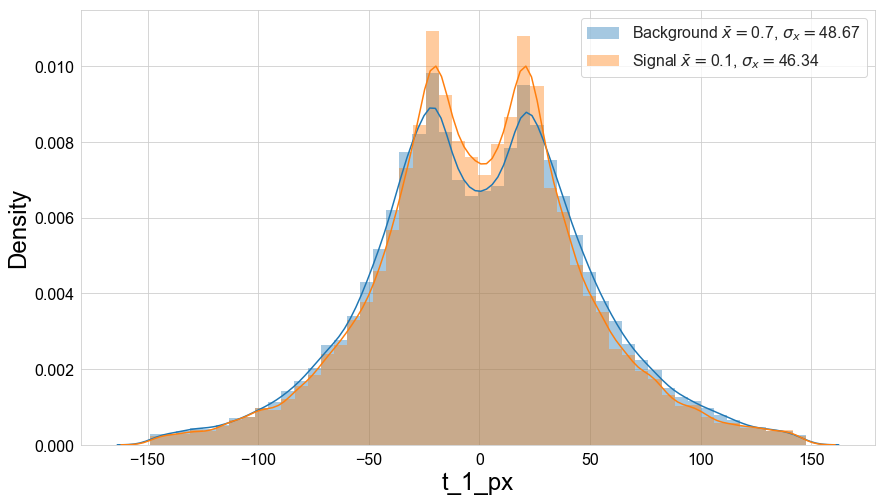

In [28]:
dist_plotter(feat='t_1_px')

Whereas other features do show a large difference

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


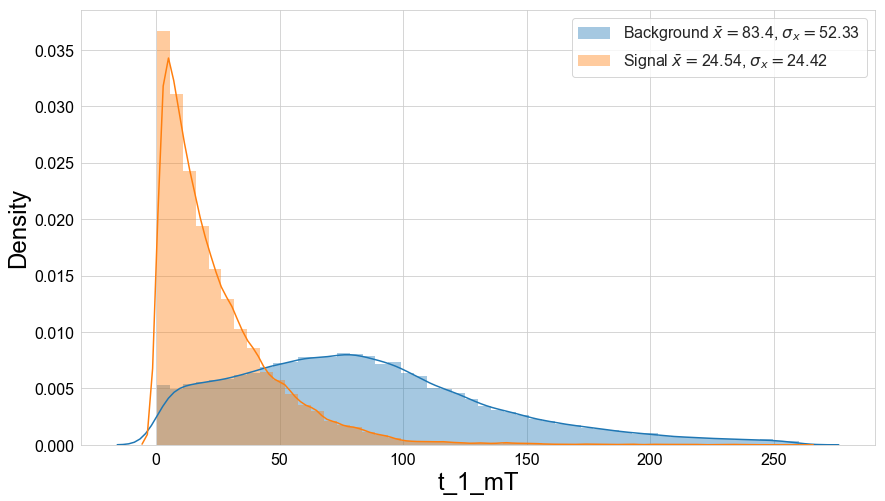

In [29]:
dist_plotter(feat='t_1_mT')

Whilst some features in isolation may not offer much separation, in combination with other features, there might well be a difference. Our *Feature selection* should aim to remove features from our training set in order to end up with only the most useful ones, and do so in a fast and automatic way. We can then check if we agree with the results.

### Initial removals
The feature selection methods we'll use will be based around Random Forests. Whilst these are quick and flexible, they are unlikely to be able to utilise the low-level information in the dataset, i.e. the momenta vectors of the particles. Therefore we'll only run the feature selection on the high-level features. The usage of the low-level will depend on your actual model, e.g. deep-leaning your own information from them with a neural network.

In [30]:
get_vecs(df, strict=True)

{'b_0', 'b_1', 'diH', 'h_bb', 'h_tt', 'h_tt_vis', 'mPT', 't_0', 't_1'}

In [31]:
ll_feats = []
keep = ['_mass', '_mT', '_E']
for v in get_vecs(df, strict=True): ll_feats += [f for f in train_df.columns if f.startswith(v)]
ll_feats = [f for f in ll_feats if '_mass' not in f and '_mT' not in f and '_E' not in f]
ll_feats

['b_0_pT',
 'b_0_eta',
 'b_0_phi',
 'b_0_px',
 'b_0_py',
 'b_0_pz',
 'b_0_absp',
 'mPT_pT',
 'mPT_phi',
 'mPT_px',
 'mPT_py',
 'mPT_absp',
 'h_tt_pT',
 'h_tt_eta',
 'h_tt_phi',
 'h_tt_px',
 'h_tt_py',
 'h_tt_pz',
 'h_tt_absp',
 'h_tt_vis_px',
 'h_tt_vis_py',
 'h_tt_vis_pz',
 'h_tt_vis_absp',
 'h_tt_vis_pT',
 'h_tt_vis_eta',
 'h_tt_vis_phi',
 'h_bb_pT',
 'h_bb_eta',
 'h_bb_phi',
 'h_bb_px',
 'h_bb_py',
 'h_bb_pz',
 'h_bb_absp',
 'h_tt_vis_px',
 'h_tt_vis_py',
 'h_tt_vis_pz',
 'h_tt_vis_absp',
 'h_tt_vis_pT',
 'h_tt_vis_eta',
 'h_tt_vis_phi',
 't_1_pT',
 't_1_eta',
 't_1_phi',
 't_1_px',
 't_1_py',
 't_1_pz',
 't_1_absp',
 'b_1_pT',
 'b_1_eta',
 'b_1_phi',
 'b_1_px',
 'b_1_py',
 'b_1_pz',
 'b_1_absp',
 't_0_pT',
 't_0_eta',
 't_0_phi',
 't_0_px',
 't_0_py',
 't_0_pz',
 't_0_absp',
 'diH_pT',
 'diH_eta',
 'diH_phi',
 'diH_px',
 'diH_py',
 'diH_pz',
 'diH_absp']

In [32]:
gen_feats = [f for f in train_df.columns if f.startswith('gen_')]; gen_feats

['gen_weight', 'gen_target']

In [33]:
hl_feats = [f for f in train_df.columns if f not in ll_feats+gen_feats]; len(hl_feats), hl_feats

(105,
 ['t_0_mass',
  't_1_mass',
  'b_0_mass',
  'b_1_mass',
  'h_tt_mass',
  'h_bb_mass',
  'diH_mass',
  'hT',
  'sT',
  'centrality',
  'eVis',
  'nJets',
  'nBJets',
  'nTauJets',
  'minJetPT',
  'meanJetPT',
  'maxJetPT',
  'minJetMass',
  'meanJetMass',
  'maxJetMass',
  'minJetEta',
  'meanJetEta',
  'maxJetEta',
  'nPhotons',
  'sphericityA',
  'spherocityA',
  'aplanarityA',
  'aplanorityA',
  'upsilonA',
  'dShapeA',
  'sphericityP',
  'spherocityP',
  'aplanarityP',
  'aplanorityP',
  'upsilonP',
  'dShapeP',
  'b_0_E',
  'h_tt_E',
  'h_bb_E',
  't_1_E',
  'b_1_E',
  't_0_E',
  'diH_E',
  'h_tt_vis_E',
  'h_tt_vis_mass',
  'hl_dphi_t0_t1',
  'hl_dphi_b0_b1',
  'hl_dphi_t0_mPT',
  'hl_dphi_t1_mPT',
  'hl_dphi_httvis_mPT',
  'hl_dphi_htt_mPT',
  'hl_dphi_hbb_mPT',
  'hl_dphi_hbb_htt',
  'hl_dphi_hbb_httvis',
  'hl_deta_t0_t1',
  'hl_deta_b0_b1',
  'hl_deta_hbb_htt',
  'hl_deta_hbb_httvis',
  'hl_dR_t0_t1',
  'hl_dR_b0_b1',
  'hl_dR_hbb_httvis',
  'hl_dR_hbb_htt',
  'hl_dR_b0_

Even with just the high-level features, there are still quite a few

### Non-generalising features
The model trained on one dataset should generalise as well as possible to other data. In high-energy physics this isn't too much of a problem, however in some cases your validation data or testing data might be drawn from different distributions, e.g. training on data from 2017 and testing data from 2018. Any general differences between the features in the two datasets can cause your model to drop in performance when applied to the new data.

We'll run a simple classification to see whether we can predict whether data belong to our training, validation, and testing sets. If we can tell the difference, then we can try removing the most important features which allow for the prediction.

In [34]:
from lumin.utils.data import check_val_set

check_val_set(train=train_df[hl_feats], val=val_df[hl_feats], test=test_df[hl_feats])


AUC for train-validation discrimination = 0.4997874855818332
Top 10 most important features are:
   index                 Feature  Importance
0      0             sphericityA    0.003661
1      2                   b_1_E    0.002903
2      1             sphericityP    0.002903
3      3           hl_deta_b0_b1    0.002525
4      4                   t_0_E    0.002525
5      5                      hT    0.002398
6      6  hl_costheta_t0_htt_vis    0.002398
7      7               hl_p_zeta    0.002398
8      8                 h_tt_mT    0.002272
9      9              centrality    0.002272

AUC for test-validation discrimination = 0.5020149682366272
Top 10 most important features are:
   index                     Feature  Importance
0      0             hl_deta_hbb_htt    0.008901
1      1         hl_twist_hbb_httvis    0.008317
2      2  hl_costheta_htt_mpt_hh_vis    0.007508
3      3  hl_dR_l0_t1_boosted_httvis    0.007328
4      4                          hT    0.007013
5      5        

From this we can tell that it is impossible to tell the three datasets apart (ROC AUC is 0.5), so performance estimations on our validation data can be expected to be representative of our performance on the testing data. Note that we never passed any *hidden* information about the testing data to the function (e.g. the target variable), so we haven't spoilt the *withheld nature* of our testing set.

### Constant features
Some features might well be constant and so can be trivially removed

In [35]:
                const = []
                for f in hl_feats:
                    if len(train_df[f].unique()) == 1:
                        print(f)
                        const += [f]
                hl_feats = [f for f in hl_feats if f not in const]

t_1_mass


Good, the method correctly found that the `t_1_mass` is constant (it's the muon mass)

### Correlated features
The main bulk of our feature selection will be based on *permutation importance*. However this only works if the features are not-correlated with one-another, otherwise the importance of both features will be decreased, since the information carried by one feature can be recovered from the other.

Really, we want to identify these correlated pairs first and try to remove one feature from each pair. This takes several steps:
1. We'll compute the Spearman's rank-order correlation coefficient for every pair of features. This only considers the order in which data-points appear when feature values are sorted in increasing value, rather than the scale of features. As such it is sensitive to monotonic relationships between features, not just linear correlations.
1. Since multiple features can be correlated with one-another, we'll cluster pairs of features by treating their correlation coefficient's as a Euclidean distance.
1. We'll then use a threshold to define which pairs of features are 'correlated' and candidates for removal testing
1. Removal testing will involve training several Random Forests and checking the average changes in performance: first when training with remaining features, next when removing one of the candidate features, and lastly when removing the other candidate feature.
1. If the performance improves or stays the same when one of the candidate features is removed, this suggests that the feature can be safely removed without damaging the potential performance of the model.

In it's current implementation, the algorithm may have to be run multiple times to check all pairs correlated features, as it currently ignores the case when a third feature is correlated with two previously clustered feature.

Since we'll be training ML algorithms, we'll need a further split on our training data to get unbiased estimates of performance.

In [36]:
trn_idxs, val_idxs = train_test_split(train_df.index, test_size=0.2, stratify=train_df.gen_target, random_state=1111)
len(train_df.loc[trn_idxs]), len(train_df.loc[val_idxs])

(89755, 22439)

The method we'll use is `lumin.optimisation.features.auto_filter_on_linear_correlation`. This first calls `lumin.plotting.data_viewing.plot_rank_order_dendrogram` to plot a dendrogram representation of the features hierarchically clustered by Spearman's rank-order correlation coefficient. The plotting method also returns pairs of clustered features in decreasing order of correlation coefficient which have a coefficient greater than `corr_threshold`.

Next it will optimise the hyper-parameters of a Random Forest on a Bootstrap resample of the training data (alternatively we can supply the hyper parameters we want to use (or indeed the range of hyper parameters we want to consider) by setting `rf_params`). `subsample_rate` can be used to only sample a fraction of the original training dataset, which is useful if we have a large dataset.

Then for each pair of correlated features, `lumin.optimisation.features.rf_check_feat_removal` will be called. This trains and evaluates a number of Random Forests (`n_rfs`) on Bootstrap resamples of the training data. If average performance is found to not decrease by removing a feature, then that feature is removed. Once all pairs have been tested, `plot_rank_order_dendrogram` will be called again to check for remaining correlations.

We recommend that users convince themselves that the features removed are valid for removal.

Since we have a relatively large dataset, we'll subsample it to just one tenth of the size by setting `subsample_rate` to 0.1.

Because know what range of hyper-parameters will be suitable for the Random Forests, we'll first optimise them separately and pass the chose parameters to the function. Note we could simply call the function without passing parameters, but it would use default ranges which may not be suitable. Note that we're optimising on a Bootstrap subsample.

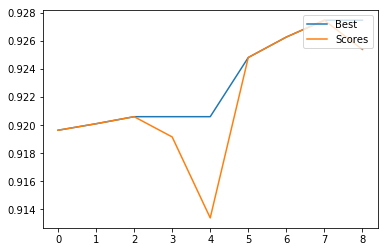

Better score schieved: min_samples_leaf @ 2 = 0.9196
Better score schieved: min_samples_leaf @ 4 = 0.9201
Better score schieved: min_samples_leaf @ 8 = 0.9206
Better score schieved: max_features @ 0.3 = 0.9248
Better score schieved: max_features @ 0.5 = 0.9263
Better score schieved: max_features @ 0.7 = 0.9275


<Figure size 432x288 with 0 Axes>

In [37]:
from lumin.utils.misc import subsample_df
from lumin.optimisation.hyper_param import get_opt_rf_params
from collections import OrderedDict

subsample_rate = 0.1

tmp_trn = subsample_df(train_df.loc[trn_idxs], 'classification', 'gen_target',
                       n_samples=int(subsample_rate*len(trn_idxs)), strat_key='gen_target', wgt_name='gen_weight')
rf_params, _ = get_opt_rf_params(x_trn=tmp_trn[hl_feats], y_trn=tmp_trn['gen_target'],
                                 x_val=train_df.loc[val_idxs][hl_feats], y_val=train_df.loc[val_idxs]['gen_target'],
                                 objective='classification',
                                 w_trn=tmp_trn['gen_weight'], w_val=train_df.loc[val_idxs]['gen_weight'],
                                 n_estimators=40, verbose=True,
                                 params=OrderedDict({'min_samples_leaf': [2,4,8,16,32],
                                                     'max_features': [0.3,0.5,0.7,0.9]}))

Computing Spearman's rank-order correlation coefficients


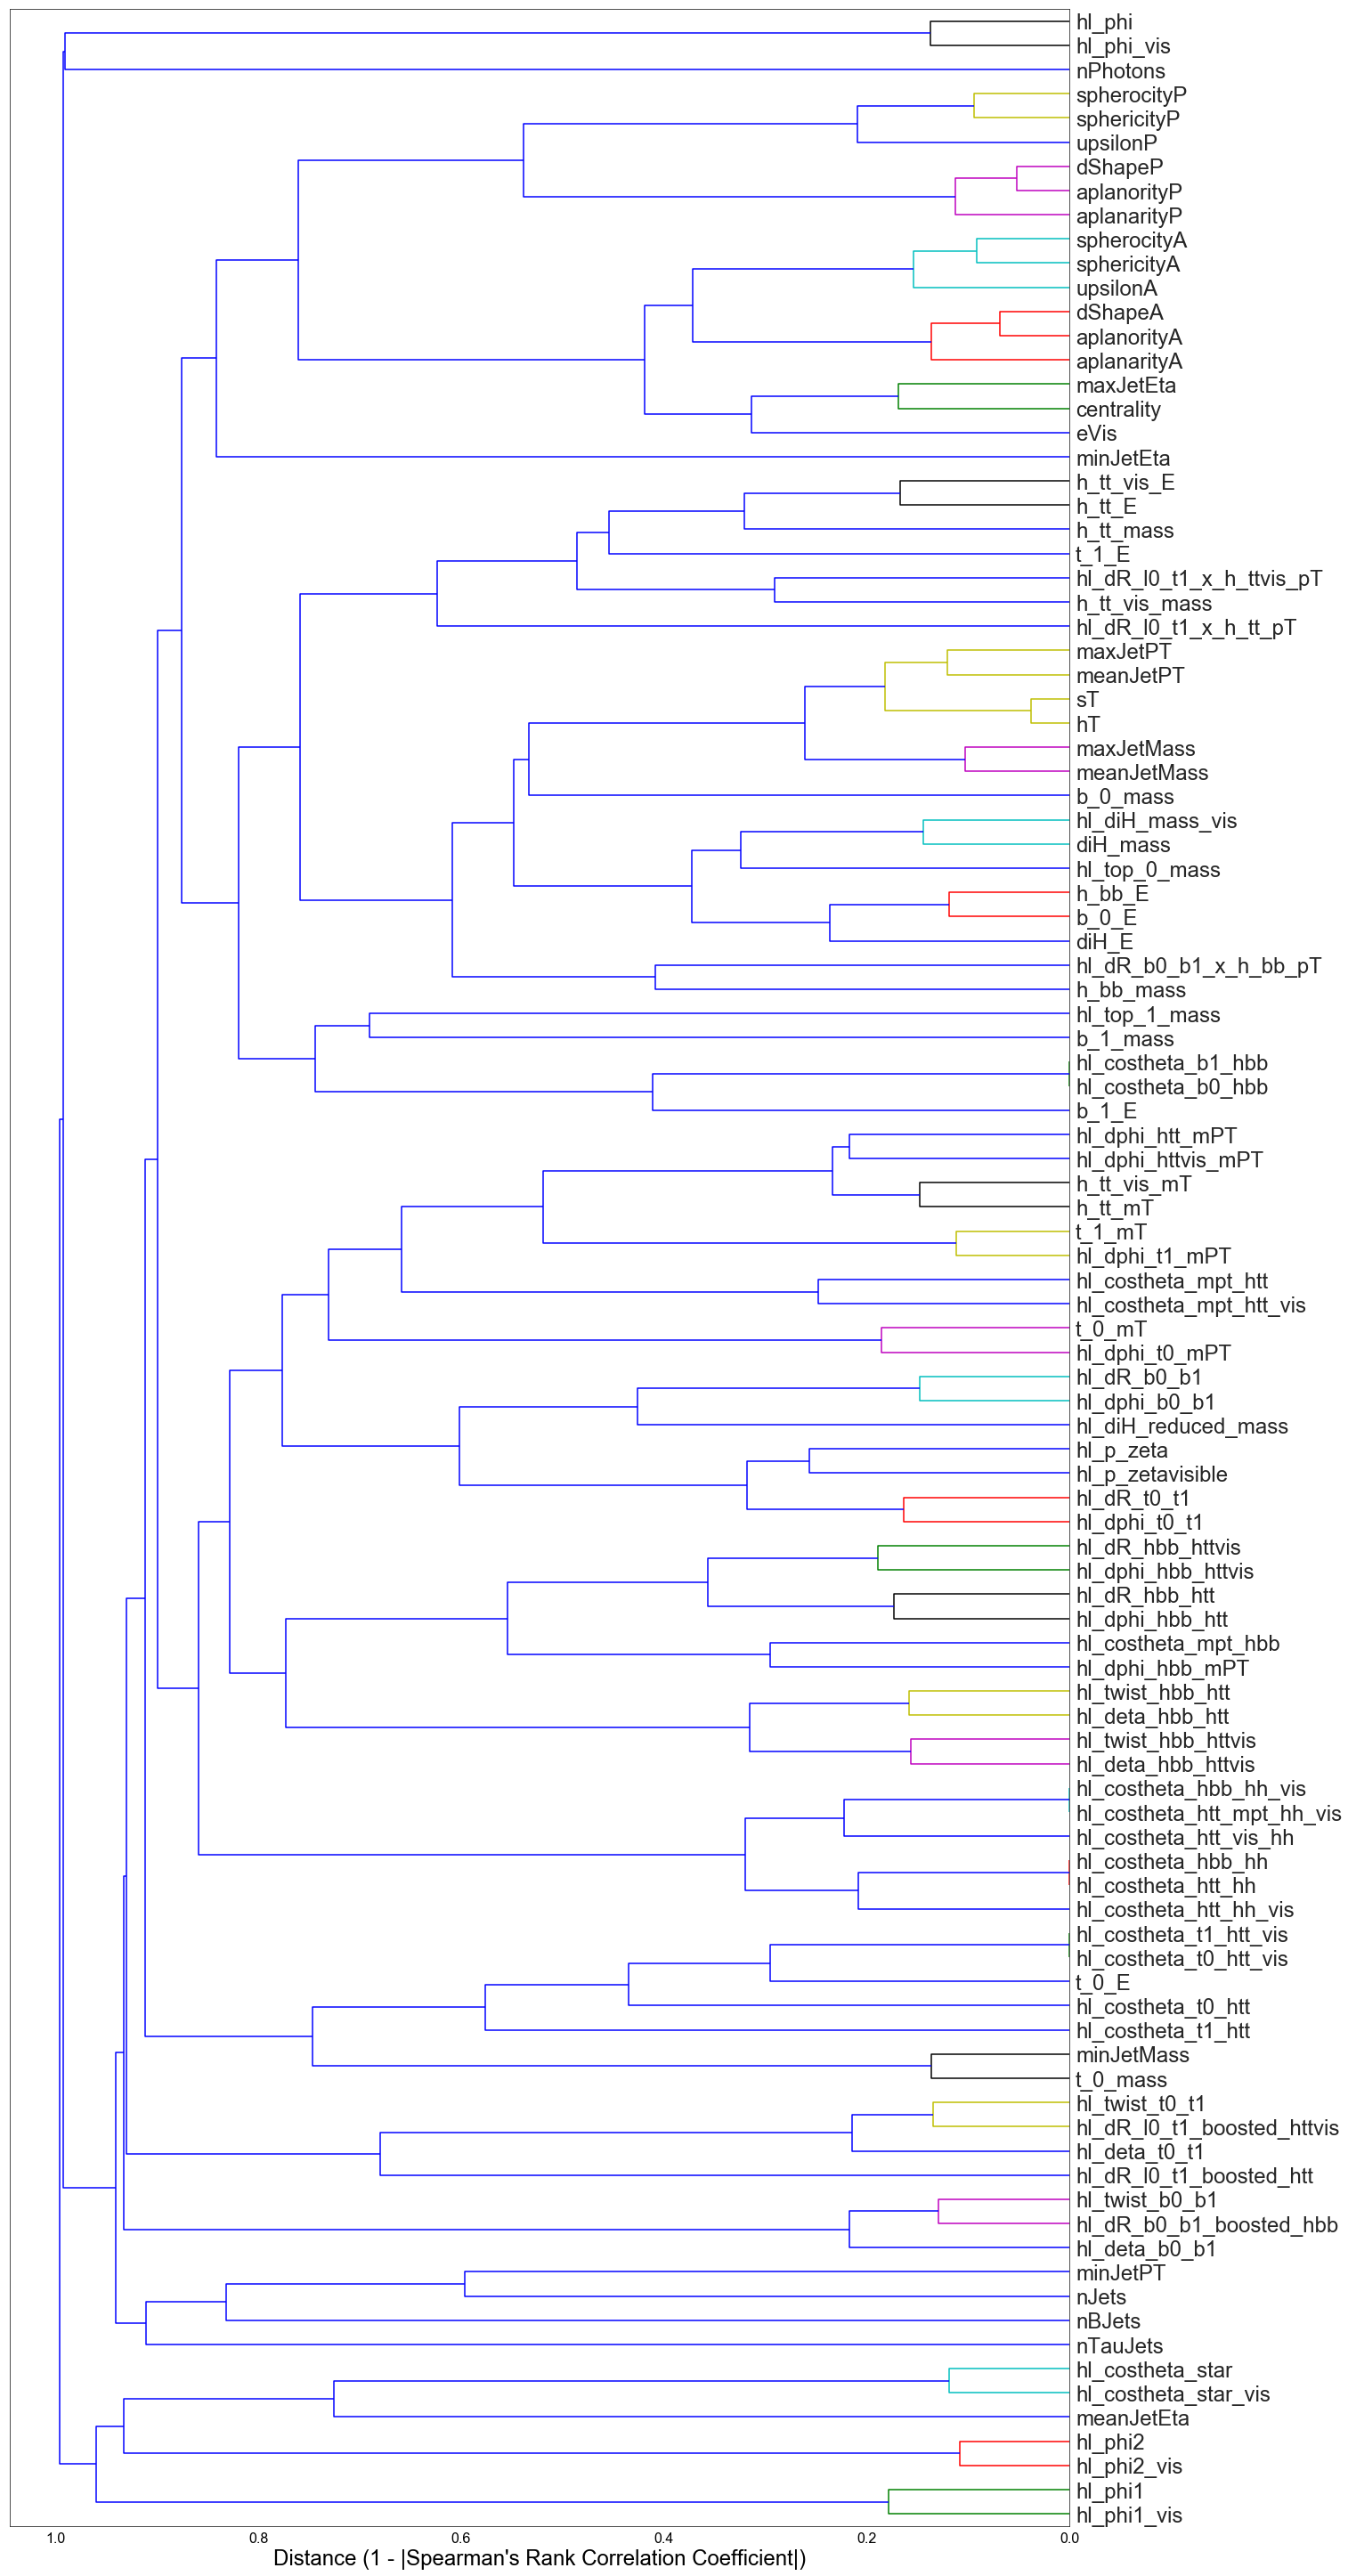

31 pairs of features found to pass correlation threshold of 0.8:
[['hl_costheta_b0_hbb', 'hl_costheta_b1_hbb'], ['hl_costheta_t0_htt_vis', 'hl_costheta_t1_htt_vis'], ['hl_costheta_htt_mpt_hh_vis', 'hl_costheta_hbb_hh_vis'], ['hl_costheta_htt_hh', 'hl_costheta_hbb_hh'], ['hT', 'sT'], ['aplanorityP', 'dShapeP'], ['aplanorityA', 'dShapeA'], ['sphericityA', 'spherocityA'], ['sphericityP', 'spherocityP'], ['meanJetMass', 'maxJetMass'], ['hl_phi2_vis', 'hl_phi2'], ['hl_dphi_t1_mPT', 't_1_mT'], ['b_0_E', 'h_bb_E'], ['hl_costheta_star_vis', 'hl_costheta_star'], ['meanJetPT', 'maxJetPT'], ['hl_dR_b0_b1_boosted_hbb', 'hl_twist_b0_b1'], ['hl_dR_l0_t1_boosted_httvis', 'hl_twist_t0_t1'], ['t_0_mass', 'minJetMass'], ['hl_phi_vis', 'hl_phi'], ['diH_mass', 'hl_diH_mass_vis'], ['hl_dphi_b0_b1', 'hl_dR_b0_b1'], ['h_tt_mT', 'h_tt_vis_mT'], ['hl_deta_hbb_httvis', 'hl_twist_hbb_httvis'], ['hl_deta_hbb_htt', 'hl_twist_hbb_htt'], ['hl_dphi_t0_t1', 'hl_dR_t0_t1'], ['h_tt_E', 'h_tt_vis_E'], ['centrality', 'max


Checking pair: ['hl_costheta_b0_hbb', 'hl_costheta_b1_hbb']
+--------------------+-------------+---------------+
|      Removed       |  OOB Score  |   Val Score   |
+--------------------+-------------+---------------+
|        None        | 0.896±0.002 | 0.8953±0.0009 |
| hl_costheta_b0_hbb | 0.899±0.004 |  0.897±0.001  |
| hl_costheta_b1_hbb | 0.898±0.002 |  0.896±0.002  |
+--------------------+-------------+---------------+
Dropping hl_costheta_b0_hbb

Checking pair: ['hl_costheta_t0_htt_vis', 'hl_costheta_t1_htt_vis']
+------------------------+-------------+-------------+
|        Removed         |  OOB Score  |  Val Score  |
+------------------------+-------------+-------------+
|          None          | 0.899±0.006 | 0.895±0.002 |
| hl_costheta_t0_htt_vis | 0.896±0.007 | 0.896±0.001 |
| hl_costheta_t1_htt_vis | 0.896±0.006 | 0.893±0.002 |
+------------------------+-------------+-------------+
Dropping hl_costheta_t0_htt_vis

Checking pair: ['hl_costheta_htt_mpt_hh_vis', 'hl_cos


Checking pair: ['h_tt_mT', 'h_tt_vis_mT']
+-------------+-------------+-------------+
|   Removed   |  OOB Score  |  Val Score  |
+-------------+-------------+-------------+
|     None    | 0.901±0.004 | 0.895±0.002 |
|   h_tt_mT   | 0.904±0.006 | 0.896±0.002 |
| h_tt_vis_mT | 0.901±0.004 | 0.895±0.003 |
+-------------+-------------+-------------+
Dropping h_tt_mT

Checking pair: ['hl_deta_hbb_httvis', 'hl_twist_hbb_httvis']
+---------------------+-------------+-------------+
|       Removed       |  OOB Score  |  Val Score  |
+---------------------+-------------+-------------+
|         None        | 0.901±0.006 | 0.896±0.003 |
|  hl_deta_hbb_httvis | 0.903±0.007 | 0.896±0.002 |
| hl_twist_hbb_httvis | 0.903±0.006 | 0.897±0.003 |
+---------------------+-------------+-------------+
Dropping hl_twist_hbb_httvis

Checking pair: ['hl_deta_hbb_htt', 'hl_twist_hbb_htt']
+------------------+-------------+-------------+
|     Removed      |  OOB Score  |  Val Score  |
+------------------+---

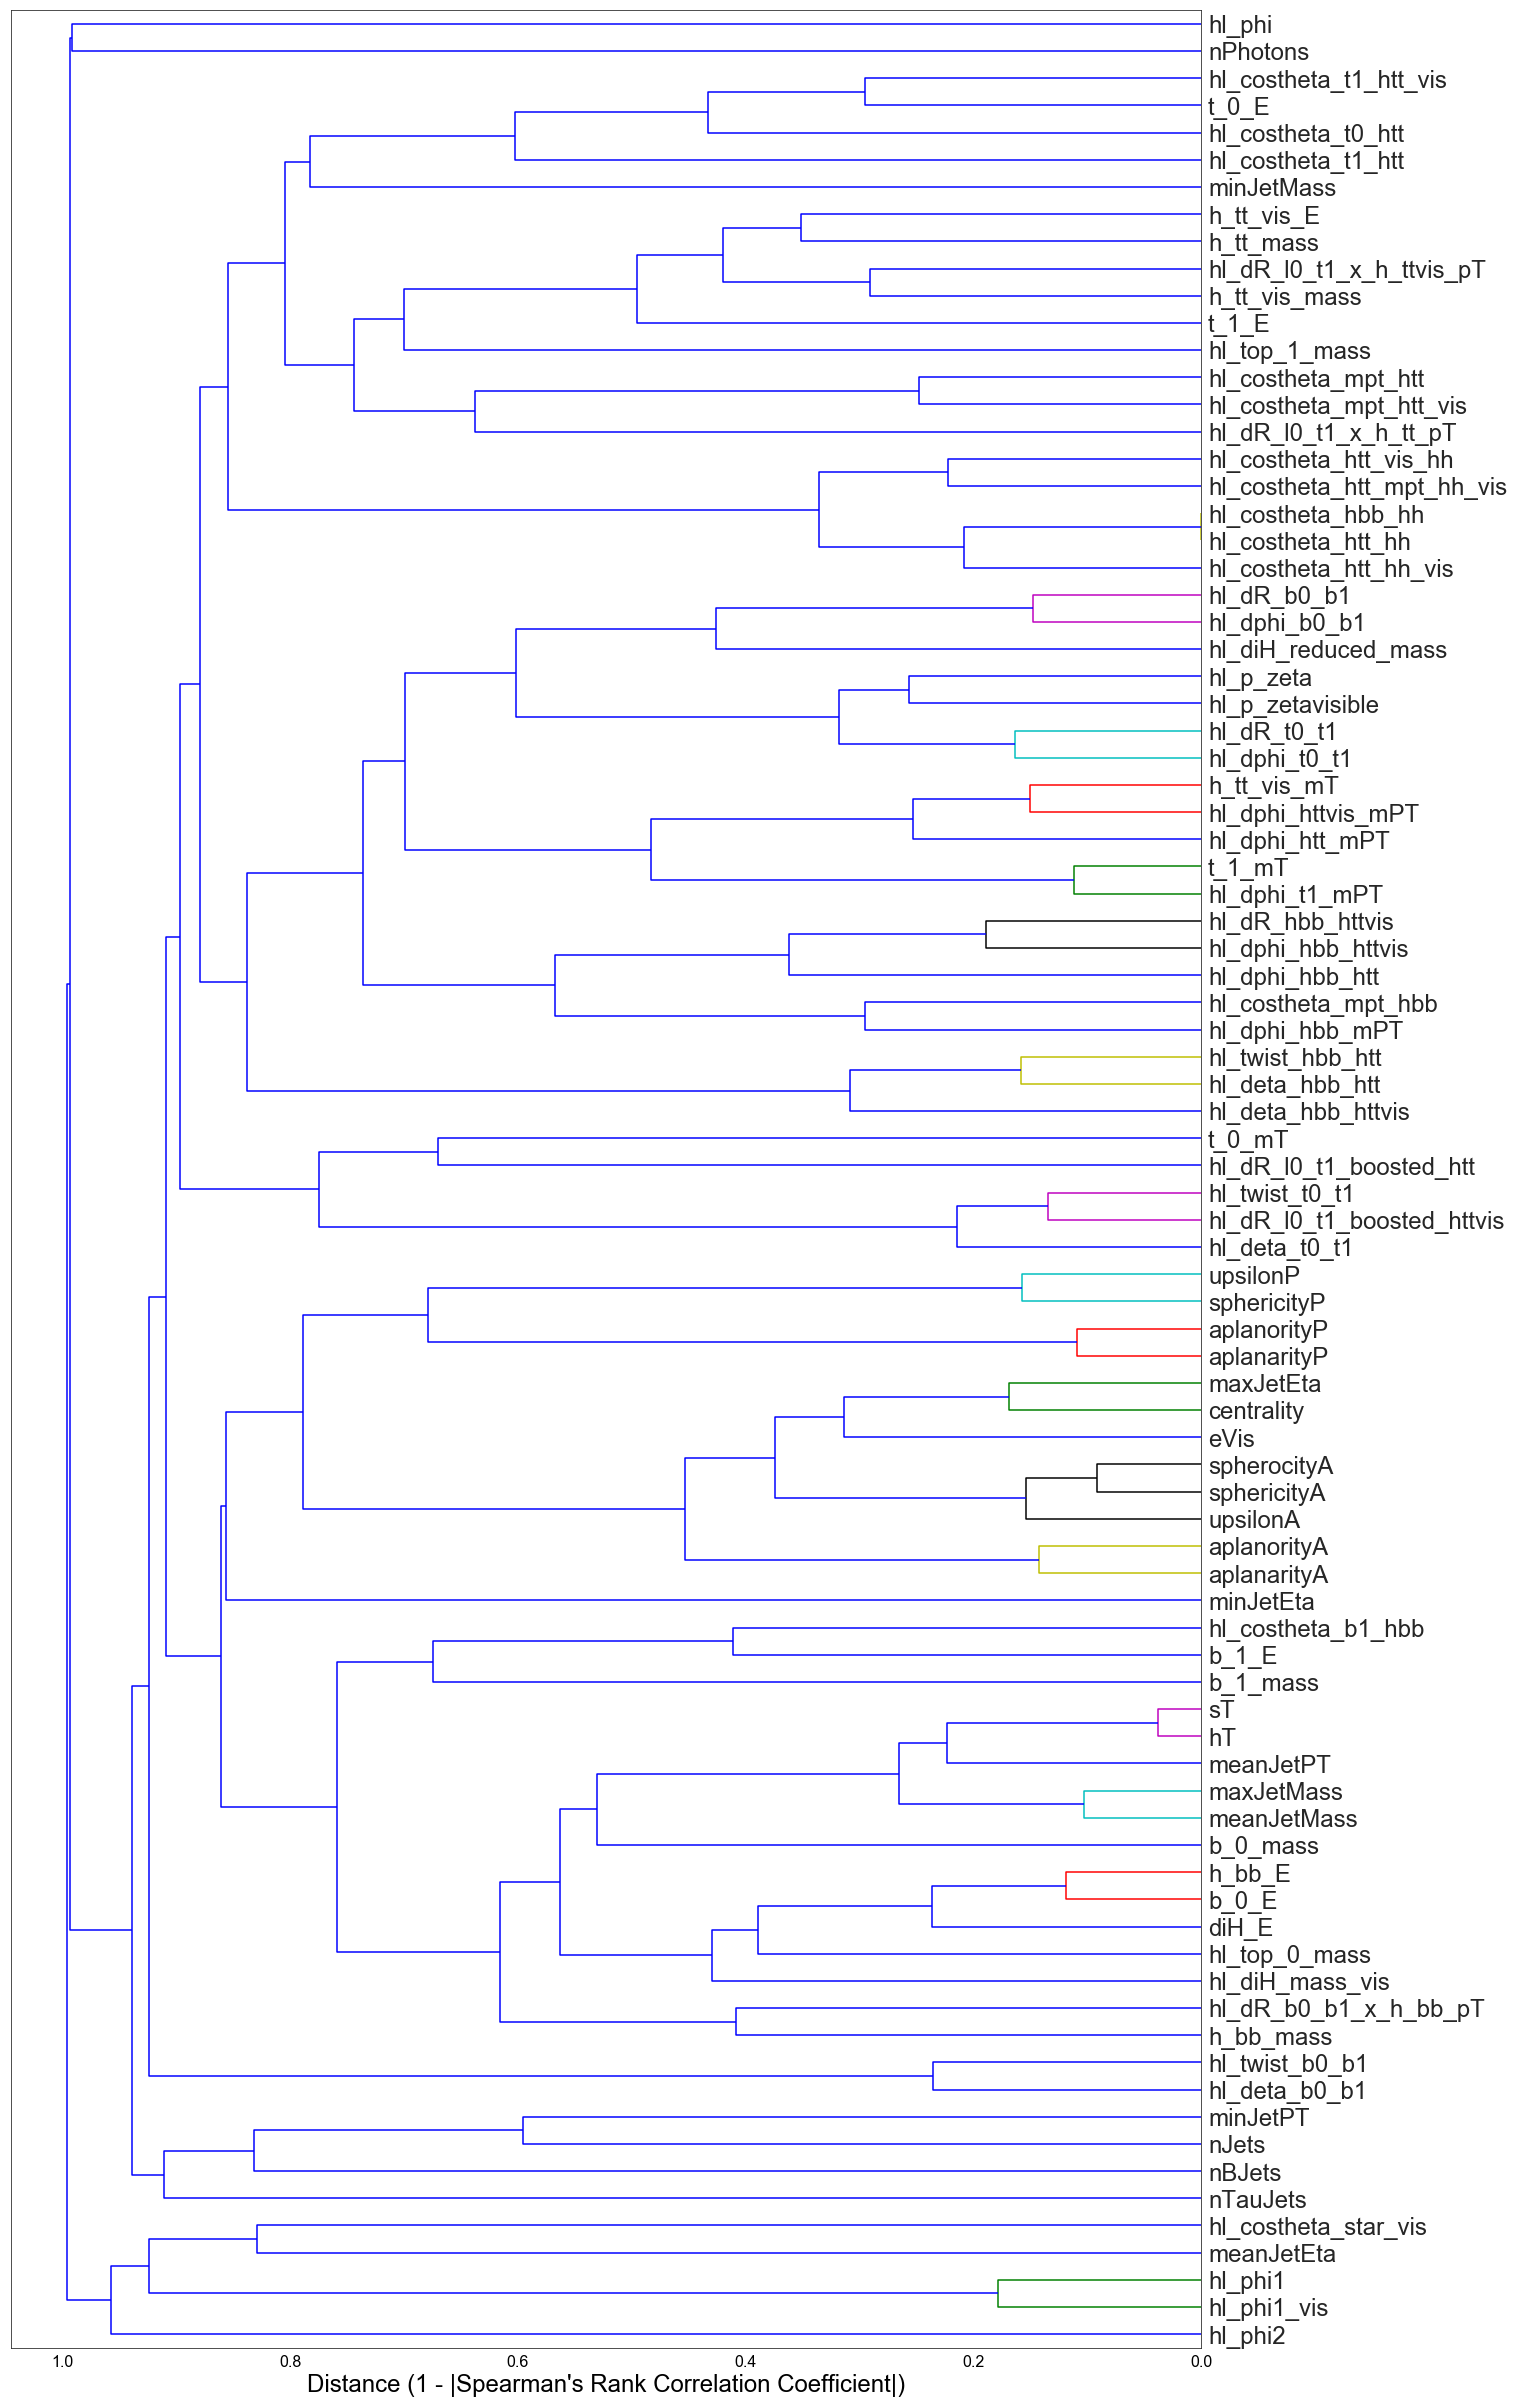

17 pairs of features still found to pass correlation threshold of 0.8. You may wish to rerun this function on the filtered features.

Comparing RF scores, higher = better
All features:		0.898±0.008
Filtered features:	0.894±0.003

Filtering took 136.161 seconds


In [38]:
from lumin.optimisation.features import auto_filter_on_linear_correlation

filtered_feats = auto_filter_on_linear_correlation(train_df=train_df.loc[trn_idxs], val_df=train_df.loc[val_idxs],
                                                   check_feats=hl_feats, subsample_rate=0.01, n_rfs=5,
                                                   corr_threshold=0.8, rf_params=rf_params, optimise_rf=False,
                                                   objective='classification', targ_name='gen_target',
                                                   wgt_name='gen_weight', strat_key='gen_target')

In [39]:
len(filtered_feats), filtered_feats

(86,
 ['b_0_mass',
  'b_1_mass',
  'h_tt_mass',
  'h_bb_mass',
  'hT',
  'sT',
  'centrality',
  'eVis',
  'nJets',
  'nBJets',
  'nTauJets',
  'minJetPT',
  'meanJetPT',
  'minJetMass',
  'meanJetMass',
  'maxJetMass',
  'minJetEta',
  'meanJetEta',
  'maxJetEta',
  'nPhotons',
  'sphericityA',
  'spherocityA',
  'aplanarityA',
  'aplanorityA',
  'upsilonA',
  'sphericityP',
  'aplanarityP',
  'aplanorityP',
  'upsilonP',
  'b_0_E',
  'h_bb_E',
  't_1_E',
  'b_1_E',
  't_0_E',
  'diH_E',
  'h_tt_vis_E',
  'h_tt_vis_mass',
  'hl_dphi_t0_t1',
  'hl_dphi_b0_b1',
  'hl_dphi_t1_mPT',
  'hl_dphi_httvis_mPT',
  'hl_dphi_htt_mPT',
  'hl_dphi_hbb_mPT',
  'hl_dphi_hbb_htt',
  'hl_dphi_hbb_httvis',
  'hl_deta_t0_t1',
  'hl_deta_b0_b1',
  'hl_deta_hbb_htt',
  'hl_deta_hbb_httvis',
  'hl_dR_t0_t1',
  'hl_dR_b0_b1',
  'hl_dR_hbb_httvis',
  'hl_dR_b0_b1_x_h_bb_pT',
  'hl_dR_l0_t1_x_h_ttvis_pT',
  'hl_dR_l0_t1_x_h_tt_pT',
  'hl_dR_l0_t1_boosted_httvis',
  'hl_dR_l0_t1_boosted_htt',
  'hl_twist_t0_t1'

In the first plot, a range of correlated features were identified and highlighted in non-blue.

A suitable set of hyper-parameters for a Random Forest classifier were found. Then each pair of features were checked for removal by considering the change in validation score.

Based on this a number of features are removed. A few un-tested correlated features remain, so we may wish to rerun the method on the filtered features, but for now we'll leave it and move on.

### Permutation Importance of Features
Having accounted for most correlated features, we can now move to compute the permutation importance of each feature. We can then only select the useful features by setting a threshold of say 0.1%. `lumin.optimisation.features rf_rank_features` rank features by their permutation importance and then returns a list of features which pass the threshold (`importance_cut`). For additional robustness, `rf_rank_features` computes the feature importance multiple times and averages to see whether the feature passes the threshold.

At the end the method will compare the performance of Random Forests trained on all the features and just the important feature. Since the hyper-parameters may not be suitable for both feature sets, we'll allow the method to optimise the hyper-parameters itself. It will them re-optimise the parameters for the RF trained on the important features.

Optimising RF parameters


Evalualting importances


Top ten most important features:
                   Feature  Importance
0     hl_diH_reduced_mass    0.146691
1                  t_1_mT    0.080617
2           h_tt_vis_mass    0.042312
3               h_bb_mass    0.031333
4   hl_dR_l0_t1_x_h_tt_pT    0.025665
6             hl_dR_b0_b1    0.008124
5          hl_dphi_t1_mPT    0.007851
7             h_tt_vis_mT    0.006442
9      hl_dphi_httvis_mPT    0.005456
10              h_tt_mass    0.004438


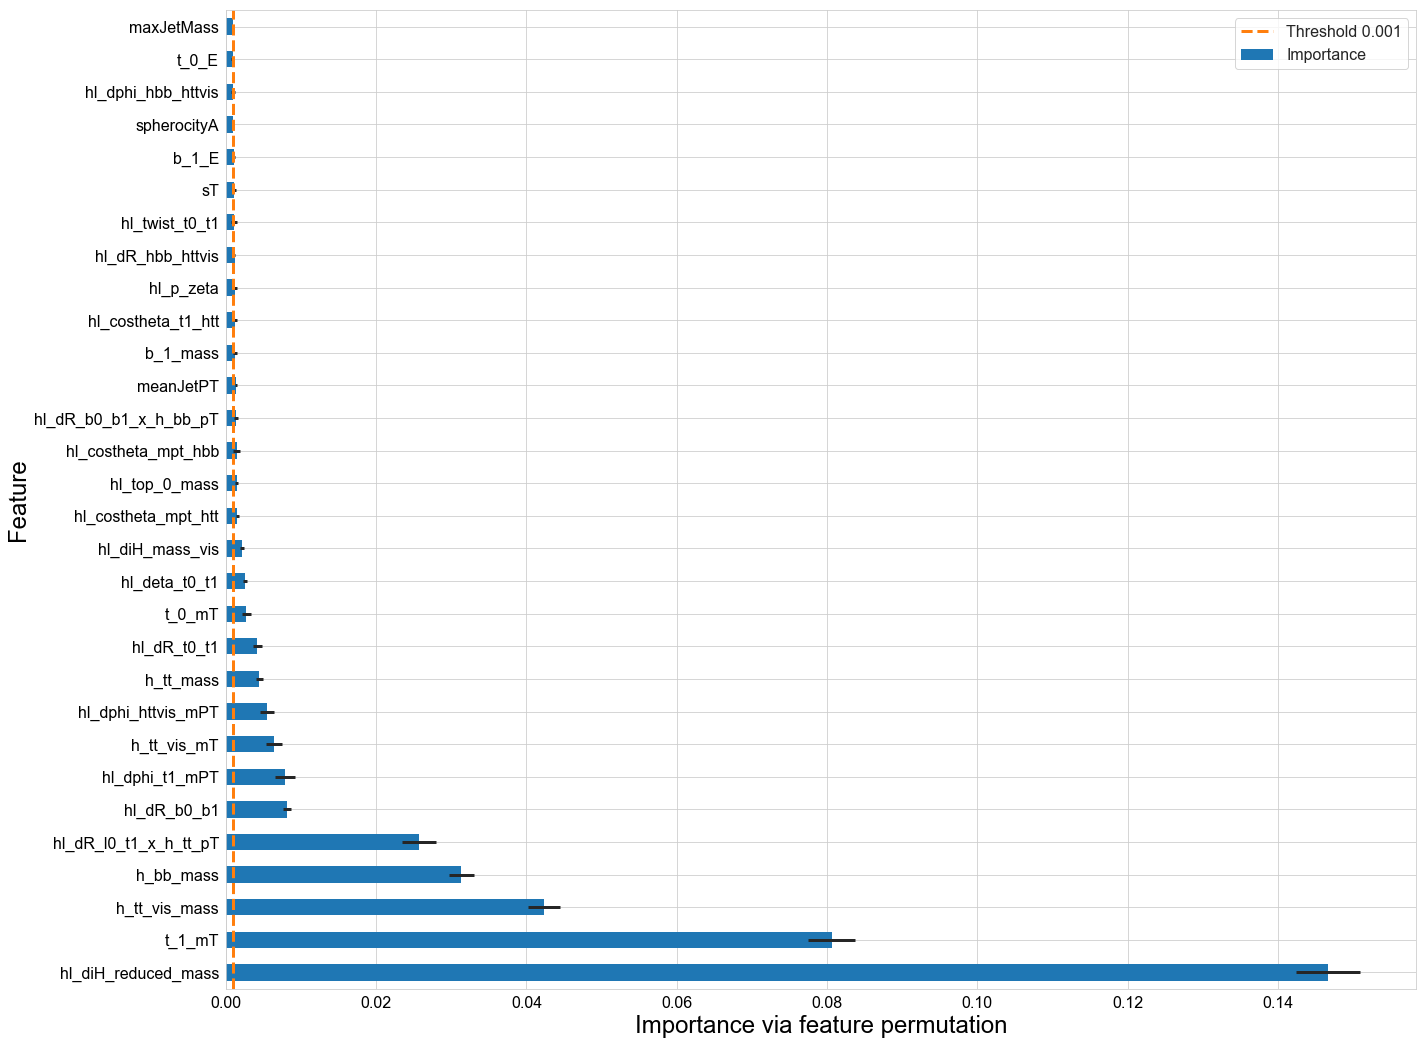


26 features found with importance greater than 0.001:
 ['hl_diH_reduced_mass', 't_1_mT', 'h_tt_vis_mass', 'h_bb_mass', 'hl_dR_l0_t1_x_h_tt_pT', 'hl_dR_b0_b1', 'hl_dphi_t1_mPT', 'h_tt_vis_mT', 'hl_dphi_httvis_mPT', 'h_tt_mass', 'hl_dR_t0_t1', 't_0_mT', 'hl_deta_t0_t1', 'hl_diH_mass_vis', 'hl_costheta_mpt_htt', 'hl_top_0_mass', 'hl_costheta_mpt_hbb', 'hl_dR_b0_b1_x_h_bb_pT', 'meanJetPT', 'b_1_mass', 'hl_costheta_t1_htt', 'hl_p_zeta', 'hl_dR_hbb_httvis', 'hl_twist_t0_t1', 'sT', 'b_1_E'] 

Optimising new RF


Comparing RF scores, higher = better
All features:		0.926±0.001
Important features:	0.9266±0.0006


In [40]:
from lumin.optimisation.features import rf_rank_features

_ = rf_rank_features(train_df=tmp_trn, val_df=train_df.loc[val_idxs], objective='classification',
                     train_feats=filtered_feats, targ_name='gen_target', wgt_name='gen_weight',
                     importance_cut=0.001,
                     rf_params=OrderedDict({'min_samples_leaf': [2,4,8,16,32],
                                            'max_features': [0.3,0.5,0.7,0.9]}), n_rfs=5, optimise_rf=True)

So, the method was able to filter out quite a few features, which resulted in an improvement in performance.

However, from the error bars, we can see that the importance of each feature can change quite a bit, and repeated checks on different datasets and models may return different sets of important features.

To get a more robust set of useful features, we can repeat the full process of training, and evaluation multiple times and check the frequency with which each feature passes the importance threshold. `lumin.optimisation.features.repeated_rf_rank_features` does just this. It repeatedly resamples the training data and passes it to `lumin.optimisation.features rf_rank_features`, and then returns the features which are selected as 'important' with a frequency greater than `min_frac_import`.

For small datasets, a lot of time can be spent on evaluating the feature importance rather that training the model, i.e  the CPU is mostly idle. `repeated_rf_rank_features` therefore supports multithreading, for simultaneous runnings of `rf_rank_features` by setting `n_threads`.

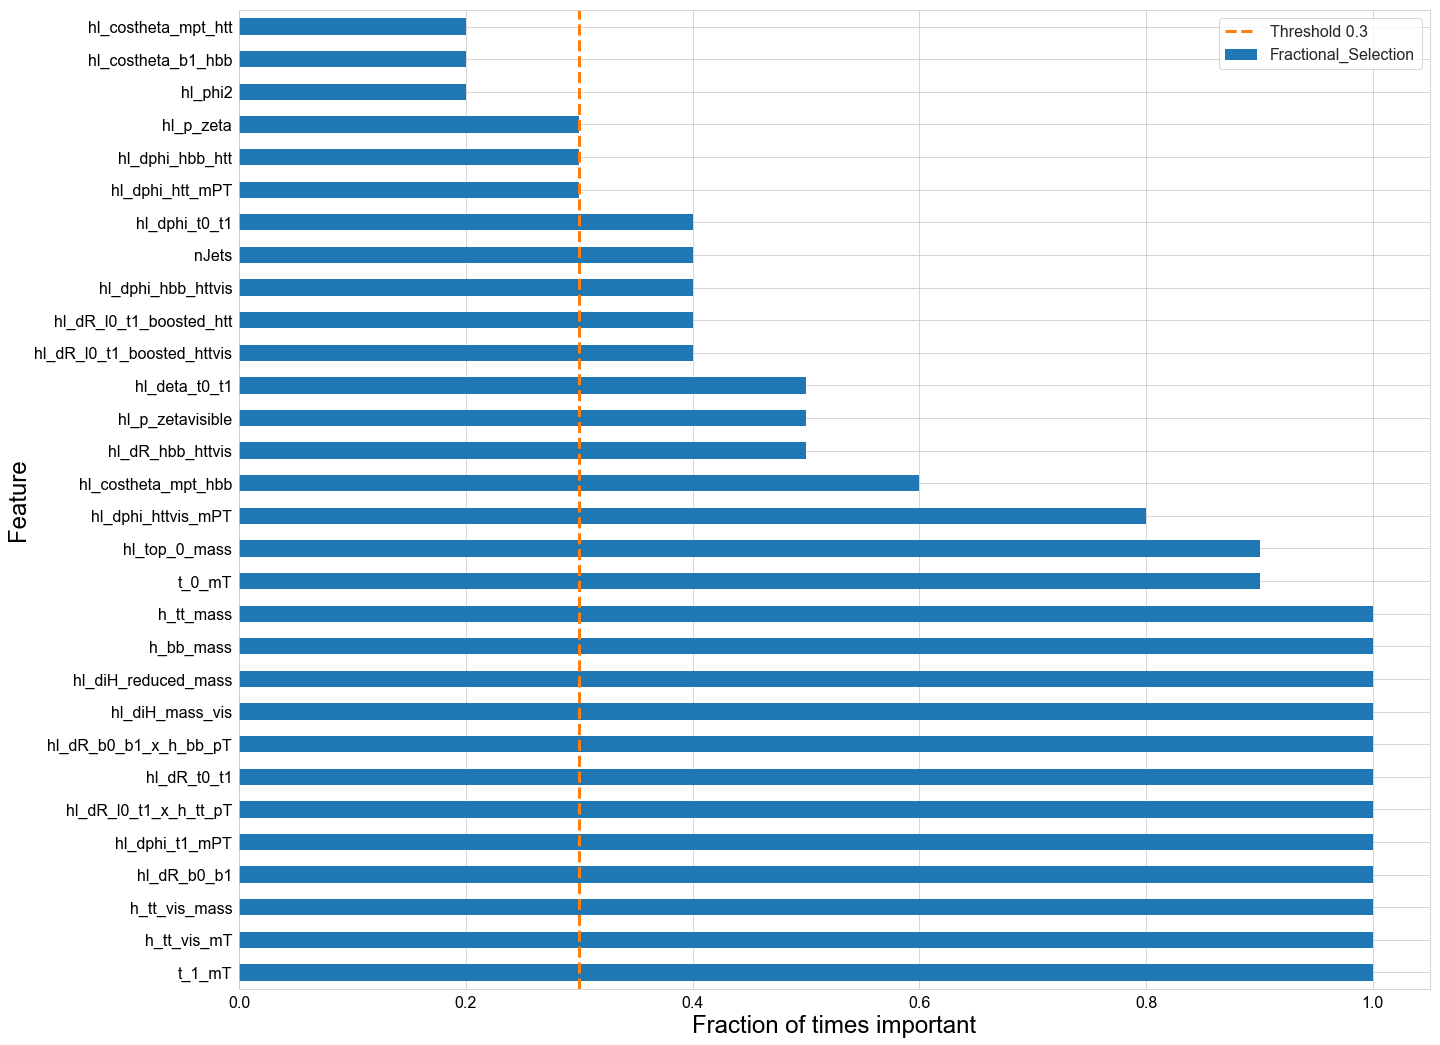


27 features found with fractional selection greater than 0.3:
 ['t_1_mT', 'h_tt_vis_mT', 'h_tt_vis_mass', 'hl_dR_b0_b1', 'hl_dphi_t1_mPT', 'hl_dR_l0_t1_x_h_tt_pT', 'hl_dR_t0_t1', 'hl_dR_b0_b1_x_h_bb_pT', 'hl_diH_mass_vis', 'hl_diH_reduced_mass', 'h_bb_mass', 'h_tt_mass', 't_0_mT', 'hl_top_0_mass', 'hl_dphi_httvis_mPT', 'hl_costheta_mpt_hbb', 'hl_dR_hbb_httvis', 'hl_p_zetavisible', 'hl_deta_t0_t1', 'hl_dR_l0_t1_boosted_httvis', 'hl_dR_l0_t1_boosted_htt', 'hl_dphi_hbb_httvis', 'nJets', 'hl_dphi_t0_t1', 'hl_dphi_htt_mPT', 'hl_dphi_hbb_htt', 'hl_p_zeta'] 



Comparing RF scores, higher = better
All features:		0.926±0.002
Selected features:	0.927±0.001


In [41]:
from lumin.optimisation.features import repeated_rf_rank_features

import_feats, fi = repeated_rf_rank_features(train_df=train_df.loc[trn_idxs], val_df=train_df.loc[val_idxs],
                                             n_reps=10, min_frac_import=0.3,
                                             rf_params=OrderedDict({'min_samples_leaf': [2,4,8,16,32],
                                                                    'max_features': [0.3,0.5,0.7,0.9]}),
                                             strat_key='gen_target', objective='classification',
                                             subsample_rate=subsample_rate, resample_val=True,
                                             train_feats=filtered_feats, wgt_name='gen_weight', importance_cut=0.001,
                                             n_rfs=5, n_threads=5)

From this we can see that there are several features which are always important (fraction of times important = 1), and there are other features which are only selected as important some of the time, which could be due to randomness of the feature subsampling in the Random Forests, or noise in the features themselves due to the bootstrap resampling. To account for this we select features which are important at least a certain fraction of the time, in this case 0.3.

Unfortunately, although we were able to significantly reduce the number of features considered, the model performance has also slightly dropped. `min_frac_import` and `importance_cut` are probably the two most important parameters for the feature selection approach presented here, so it's probably worth spending sometime adjusting them to your particular dataset. It's worth noting that the second element of the return is a Pandas DataFrame containing the features and their number of times selected:

In [42]:
fi.head()

,Feature,N_Selections,Fractional_Selection
80,t_1_mT,10,1.0
81,h_tt_vis_mT,10,1.0
36,h_tt_vis_mass,10,1.0
50,hl_dR_b0_b1,10,1.0
39,hl_dphi_t1_mPT,10,1.0


### Mutual dependence of features
A further criterion for removal of features is to identify redundant features whose values can easily be predicted using the other features. In order to evaluate this we can treat each feature in turn as the target for a Random Forest regression model, which takes the other features as inputs. A threshold can then be placed on the regressor score, $r^2$, and features with a high *dependence* are candidates for removal.

It is possible, however, that a feature with a high dependence is later relied on to predict the values of another feature with a high dependence, and removing both features would then decrease the performance of the model. By computing the permutation importance of the features for each regressor, we can check to see whether a dependent feature is also important for predicting another dependent feature.

`lumin.optimisation.features.auto_filter_on_mutual_dependence` will use `rfpimp.feature_dependence_matrix` to compute the dependencies of all features, and the permutaion importances for all regressors. Features with a dependence greater than or equal to `md_threshold` are candidates for removal. The function expects the features (`check_feats`) to be ordered in terms of decreasing importance. `lumin.optimisation.features.rf_check_feat_removal` is then used, but this time multiple features are considered for removal by selecting as many dependent features as possible (starting from the least important) up until a removal candidate is important in predicting another dependent feature. At this point, the removal check is run and any feature whose removal does not spoil the model's performance is removed. the mutual dependencies are then recomputed considering only the remaining features and the cycle repeats until no more features are removed.

Again, we would urge users to convince themselves that the features which get removed make sense.

Computing mutual dependencies


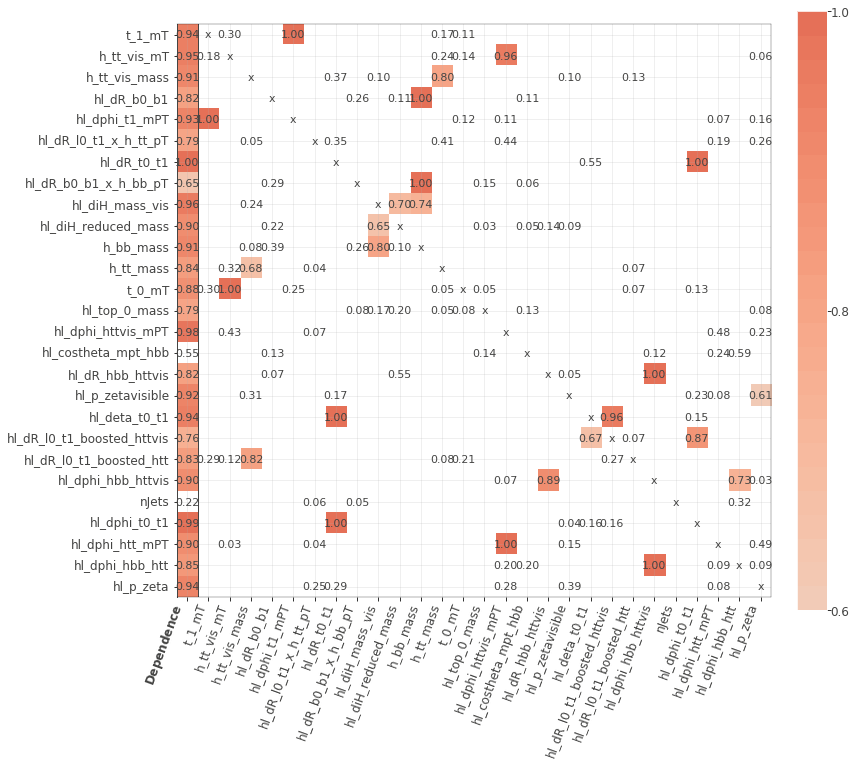


21 predictable features found to pass mutual dependence threshold of 0.8

Optimising RF


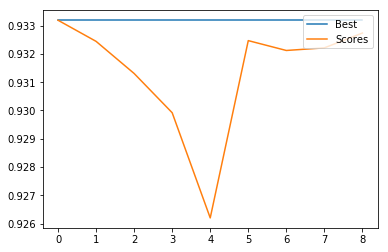

Better score schieved: min_samples_leaf @ 2 = 0.9332

Checking ['hl_p_zeta', 'hl_dphi_hbb_htt']
+-----------------+---------------+---------------+
|     Removed     |   OOB Score   |   Val Score   |
+-----------------+---------------+---------------+
|       None      | 0.9333±0.0006 | 0.9335±0.0007 |
|    hl_p_zeta    | 0.9336±0.0004 |  0.934±0.0005 |
| hl_dphi_hbb_htt | 0.9344±0.0006 |  0.934±0.0006 |
+-----------------+---------------+---------------+
Dropping hl_p_zeta
Dropping hl_dphi_hbb_htt

18 predictable features found to pass mutual dependence threshold of 0.8

Checking ['hl_dphi_htt_mPT', 'hl_dphi_t0_t1']
+-----------------+---------------+---------------+
|     Removed     |   OOB Score   |   Val Score   |
+-----------------+---------------+---------------+
|       None      |  0.935±0.0004 | 0.9339±0.0003 |
| hl_dphi_htt_mPT | 0.9342±0.0004 | 0.9338±0.0004 |
|  hl_dphi_t0_t1  | 0.9346±0.0007 | 0.9334±0.0003 |
+-----------------+---------------+---------------+

19 predict

<Figure size 432x288 with 0 Axes>

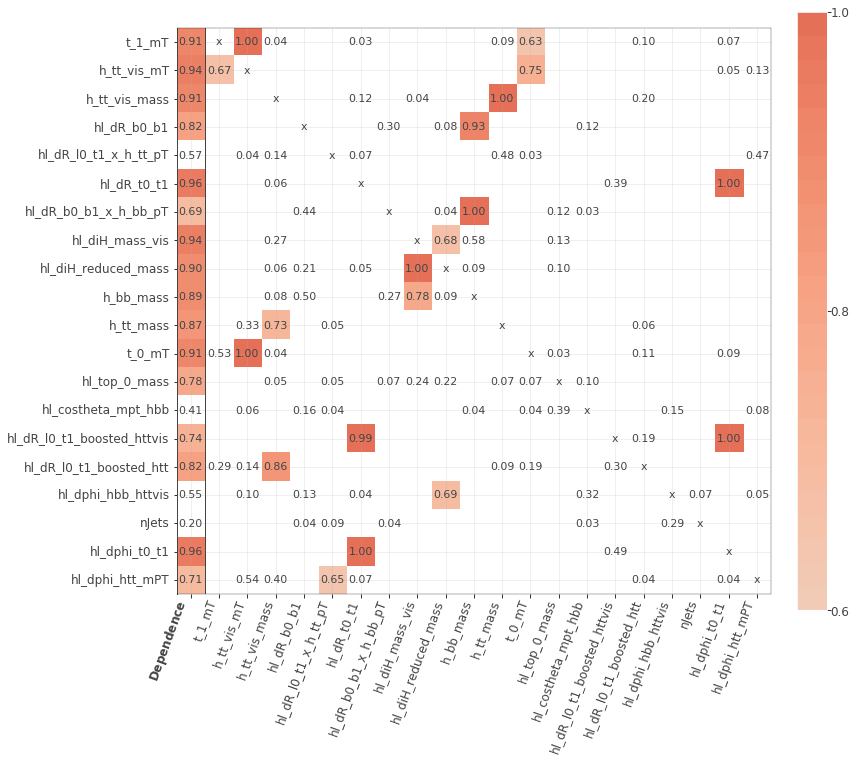


12 predictable features found to pass mutual dependence threshold of 0.8
Comparing RF scores, higher = better
All features:		0.9339±0.0006
Filtered features:	0.934±0.001

Filtering took 332.160 seconds


In [43]:
from lumin.optimisation.features import auto_filter_on_mutual_dependence

filtered_feats = auto_filter_on_mutual_dependence(train_df=train_df.loc[trn_idxs], val_df=train_df.loc[val_idxs],
                                                  check_feats=import_feats,
                                                  objective='classification', targ_name='gen_target',
                                                  strat_key='gen_target', wgt_name='gen_weight',
                                                  subsample_rate=0.3,
                                                  rf_params=OrderedDict({'min_samples_leaf': [2,4,8,16,32],
                                                                         'max_features': [0.3,0.5,0.7,0.9]}),
                                                  optimise_rf=True)

So we were able to remove a few redundant features, and also get a slight improvement in performance!